# Exploratory Data Analysis of Elo Rating Under Different Time Controls and Chess Opening Outcomes

In [2]:
# DataFrame library
import pandas as pd

# Plotting library
import matplotlib.pyplot as plt

# Statistics plotting library based on matplotlib
import seaborn as sns

# Array library
import numpy as np

# Regular expression library for text parsing and extraction
import re

# Datetime library
import datetime as dt

In [3]:
chess_games = pd.read_csv("./data/chess_games.csv")

In [4]:
# Gives us an overview of the combined dataframe
chess_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               2592 non-null   object 
 1   pgn               2592 non-null   object 
 2   time_control      2592 non-null   object 
 3   end_time          2592 non-null   int64  
 4   rated             2592 non-null   bool   
 5   tcn               2592 non-null   object 
 6   uuid              2592 non-null   object 
 7   initial_setup     2592 non-null   object 
 8   fen               2592 non-null   object 
 9   time_class        2592 non-null   object 
 10  rules             2592 non-null   object 
 11  eco               2591 non-null   object 
 12  white.rating      2592 non-null   int64  
 13  white.result      2592 non-null   object 
 14  white.@id         2592 non-null   object 
 15  white.username    2592 non-null   object 
 16  white.uuid        2592 non-null   object 


In [5]:
chess_games["start_time"] = pd.to_datetime(chess_games["start_time"], unit = "s")
chess_games["end_time"] = pd.to_datetime(chess_games["end_time"], unit = "s")

In [6]:
chess_games.describe()

,end_time,white.rating,black.rating,start_time,accuracies.white,accuracies.black
count,2592,2592.000000,2592.000000,68,1477.000000,1477.000000
mean,2024-08-12 18:48:42.732252928,619.241512,618.815972,2024-05-12 06:33:41.397058816,70.748849,69.531435
min,2023-01-18 02:08:39,100.000000,100.000000,2023-01-19 01:15:56,26.880000,18.410000
25%,2024-03-05 22:30:15,422.000000,427.000000,2023-12-31 15:36:18,63.330000,62.520000
50%,2024-08-29 02:05:29,626.000000,626.500000,2024-04-16 20:13:45.500000,71.350000,70.510000
75%,2025-02-27 18:51:00.249999872,822.250000,821.000000,2024-09-03 00:29:16.500000,79.370000,77.710000
max,2025-06-19 04:38:37,1509.000000,1501.000000,2025-05-27 19:02:43,100.000000,100.000000
std,NaN,231.591152,231.069772,NaN,12.308309,12.495977


In [7]:
# The columns currently in the dataframe
chess_games.columns

Index(['url', 'pgn', 'time_control', 'end_time', 'rated', 'tcn', 'uuid',
       'initial_setup', 'fen', 'time_class', 'rules', 'eco', 'white.rating',
       'white.result', 'white.@id', 'white.username', 'white.uuid',
       'black.rating', 'black.result', 'black.@id', 'black.username',
       'black.uuid', 'start_time', 'accuracies.white', 'accuracies.black',
       'tournament'],
      dtype='object')

In [8]:
columns_to_drop = ["time_control", "tournament", "rated", "tcn", "uuid", "initial_setup", "accuracies.white", "accuracies.black", 
                   "fen", "white.@id", "white.uuid", "black.@id", "black.uuid"]
chess_games.drop(columns = columns_to_drop, inplace = True)

In [9]:
# Types of games that were played
chess_games["time_class"].unique()

array(['blitz', 'bullet', 'daily', 'rapid'], dtype=object)

In [10]:
# Unique results for white and black (it will be the same results regardless of what column gets picked)
print(np.sort(chess_games["white.result"].unique()))

['abandoned' 'agreed' 'checkmated' 'insufficient' 'repetition' 'resigned'
 'stalemate' 'timeout' 'timevsinsufficient' 'win']


In [11]:
def game_result(df):
    """Determines whether a game was won, lost, or drawn and puts it in a list. 
    The intention is to create another column that can list the result per game regardless of what color was played.

    Args:
        df (pandas.DataFrame): the data that contains all the chess games

    Returns:
        list : Returns a list of outcomes that are one of the three states (Won, Lost, or Draw)
    """
    results = []
    for white_result, white_username, black_result, black_username in zip(df["white.result"], df["white.username"], df["black.result"], df["black.username"]):
        if (white_result == "win" and white_username == "hfactor13") or (black_result == "win" and black_username == "hfactor13"):
            results.append("Won")
        elif white_result == black_result:
            results.append("Draw")
        else:
            results.append("Lost")
    return results

In [12]:
chess_games["game_result"] = game_result(chess_games) 

In [13]:
def my_rating(df):
    """This aggregates rating for all time regardless of the colored piece played.

    Args:
        df (pandas.DataFrame): the data that contains all the chess games

    Returns:
        list: Returns a list of ratings
    """
    rating = []
    for white_rating, black_rating, white_username, black_username in zip(df["white.rating"], df["black.rating"], df["white.username"], df["black.username"]):
        if white_username == "hfactor13":
            rating.append(white_rating)
        elif black_username == "hfactor13":
            rating.append(black_rating)
    return rating

In [14]:
chess_games["my_rating"] = my_rating(chess_games)

In [15]:
# Writes out PGN data to a file (this will be helpful to extract missing information that wasn't already available in the API)
pgn_data = chess_games["pgn"]
with open("./data/pgn_data.pgn", "w") as p:
    p.writelines(pgn_data + "\n")

In [16]:
# Reads in the data from the newly created PGN file to extract information (i.e. the start and end times and the dates)
with open("./data/pgn_data.pgn", "r") as p:
    pgn_text = p.readlines()
pgn_text[:24]

['[Event "Live Chess"]\n',
 '[Site "Chess.com"]\n',
 '[Date "2023.01.18"]\n',
 '[Round "-"]\n',
 '[White "hfactor13"]\n',
 '[Black "MrEvi10verlord"]\n',
 '[Result "0-1"]\n',
 '[CurrentPosition "r6k/ppp4p/2n1r3/8/1nPp4/1P3p2/P1q5/RK4R1 w - -"]\n',
 '[Timezone "UTC"]\n',
 '[ECO "A01"]\n',
 '[ECOUrl "https://www.chess.com/openings/Nimzowitsch-Larsen-Attack-Modern-Variation"]\n',
 '[UTCDate "2023.01.18"]\n',
 '[UTCTime "02:03:52"]\n',
 '[WhiteElo "660"]\n',
 '[BlackElo "795"]\n',
 '[TimeControl "180"]\n',
 '[Termination "MrEvi10verlord won by checkmate"]\n',
 '[StartTime "02:03:52"]\n',
 '[EndDate "2023.01.18"]\n',
 '[EndTime "02:08:39"]\n',
 '[Link "https://www.chess.com/game/live/67746611751"]\n',
 '\n',
 '1. b3 {[%clk 0:02:55.3]} 1... e5 {[%clk 0:02:59.8]} 2. Nf3 {[%clk 0:02:50.5]} 2... Nc6 {[%clk 0:02:58]} 3. g3 {[%clk 0:02:48.6]} 3... d5 {[%clk 0:02:57.8]} 4. c4 {[%clk 0:02:42.1]} 4... Bc5 {[%clk 0:02:54.4]} 5. Bb2 {[%clk 0:02:35.1]} 5... f6 {[%clk 0:02:46.2]} 6. h4 {[%clk 0:02:27.3]}

In [17]:
# Parses text for dates, times, and moves
moves = []
start_times_info = []
start_dates_info = []

for text in pgn_text:
    if re.match("\[StartTime", text):
        start_times_info.append(text)
    elif re.match("\[Date", text):
        start_dates_info.append(text)
    elif re.match("1\.", text):
        moves.append(text)

In [18]:
# Looking at the last 50 characters to determine the total number of moves in the game
last_moves = [m[-50:] for m in moves]
last_moves[:10]

['clk 0:00:07.4]} 29... Qc2# {[%clk 0:01:20.2]} 0-1\n',
 ' {[%clk 0:00:21.2]} 21. g3 {[%clk 0:00:45.3]} 1-0\n',
 '[%clk 0:00:01.1]} 25... h6 {[%clk 0:00:09.9]} 0-1\n',
 '[%clk 0:00:55.3]} 32. Rxh4 {[%clk 0:02:39.7]} 1-0\n',
 '%clk 0:00:01.4]} 26... Qb7 {[%clk 0:00:04.6]} 0-1\n',
 'clk 0:00:12.9]} 17... Qxb4 {[%clk 0:00:01.8]} 0-1\n',
 '3 {[%clk 0:02:17]} 37. Rf4 {[%clk 0:03:18.1]} 1-0\n',
 '[%clk 0:04:05.6]} 39. Qe6# {[%clk 0:04:14.9]} 1-0\n',
 '%clk 0:00:00.4]} 40... Rg6 {[%clk 0:04:13.8]} 0-1\n',
 '[%clk 0:00:05.3]} 21. Nxd4 {[%clk 0:00:13.9]} 1-0\n']

In [19]:
# Reduces the string length so that it starts with '}' and end with '.'
total_moves = [re.findall("\} \d+\.", l)[0] for l in last_moves]

# Extracts the digits which signify the total number of moves
total_moves = [int(re.findall("\d+", total)[0]) for total in total_moves]
total_moves[:10]

[29, 21, 25, 32, 26, 17, 37, 39, 40, 21]

In [20]:
start_dates_series = pd.to_datetime([re.findall("\d+\.\d+\.\d+", s)[0] for s in start_dates_info])
start_times_series = pd.to_timedelta([re.findall("\d+:\d+:\d+", s)[0] for s in start_times_info])
chess_games["start_time"] = start_dates_series + start_times_series

In [21]:
# Add the newly extracted information to the combined games dataframe
chess_games["eco"] = chess_games["eco"].apply(lambda x: str(x)[31:])
chess_games.rename(columns = {"eco": "openings", "time_class": "time_control"}, inplace = True)
chess_games["total_moves"] = total_moves

In [22]:
# Filters out games where there were possibly interruptions or just disconnected entirely
filtered_idx = (chess_games["total_moves"] > 5) & (chess_games["white.result"] != "abandoned") & (chess_games["black.result"] != "abandoned")
chess_games = chess_games[filtered_idx]
chess_games.head()

,url,pgn,end_time,time_control,rules,openings,white.rating,white.result,white.username,black.rating,black.result,black.username,start_time,game_result,my_rating,total_moves
0,https://www.chess.com/game/live/67746611751,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2023-01-18 02:08:39,blitz,chess,Nimzowitsch-Larsen-Attack-Modern-Variation,660,checkmated,hfactor13,795,win,MrEvi10verlord,2023-01-18 02:03:52,Lost,660,29
1,https://www.chess.com/game/live/67746710345,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2023-01-18 02:14:48,blitz,chess,Modern-Defense-with-1-e4-2.d4-Bg7-3.Be3,618,win,YasssQueen9,520,timeout,hfactor13,2023-01-18 02:09:23,Lost,520,21
2,https://www.chess.com/game/live/67828846779,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2023-01-19 00:57:40,bullet,chess,Nimzowitsch-Larsen-Attack-Dutch-Variation,398,timeout,hfactor13,572,win,rico24432,2023-01-19 00:55:37,Lost,398,25
3,https://www.chess.com/game/live/67828893903,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2023-01-19 01:05:01,blitz,chess,Reti-Opening-Kingside-Fianchetto-Variation,555,win,YusufAwaisu,437,resigned,hfactor13,2023-01-19 00:58:08,Lost,437,32
4,https://www.chess.com/game/live/67829440503,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",2023-01-19 01:15:26,blitz,chess,Nimzowitsch-Larsen-Attack-Classical-Variation-...,348,timeout,hfactor13,367,win,DamianCapponi,2023-01-19 01:05:17,Lost,348,26


In [23]:
# Notice that there's no result called "abandoned" anymore
chess_games["white.result"].unique()

array(['checkmated', 'win', 'timeout', 'resigned', 'stalemate',
       'timevsinsufficient', 'insufficient', 'repetition', 'agreed'],
      dtype=object)

In [24]:
# Number of unique openings
chess_games["openings"].nunique()

844

In [25]:
# Maximum number of openings played for all time controls
max_num_openings_played = chess_games.groupby("openings").size().max()
max_num_openings_played

np.int64(55)

In [26]:
# Creates separate dataframes for each type of game played
blitz_games = chess_games[chess_games["time_control"] == "blitz"]
bullet_games = chess_games[chess_games["time_control"] == "bullet"]
daily_games = chess_games[chess_games["time_control"] == "daily"]
rapid_games = chess_games[chess_games["time_control"] == "rapid"]

In [27]:
def plot_game_result(df, time_control):
    """Plots the number of games won, lost, or drawn.

    Args:
        df (pandas.DataFrame): the data that contains the chess games
        time_control (str): time control used in the title for the plot
    """
    print(df.groupby("game_result").size())
    ax = df.groupby("game_result").size().plot(kind = "bar", title = f"{time_control} Time Control")
    ax.set_yticks([int(ticks) for ticks in ax.get_yticks()])
    ax.set_ylabel("Number of Games Played")
    plt.show()

game_result
Lost    24
Won     39
dtype: int64


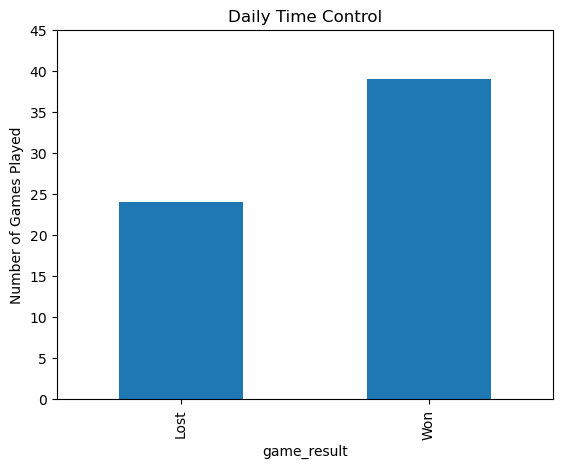

In [28]:
plot_game_result(daily_games, "Daily")

**Figure 1**

game_result
Draw     53
Lost    412
Won     435
dtype: int64


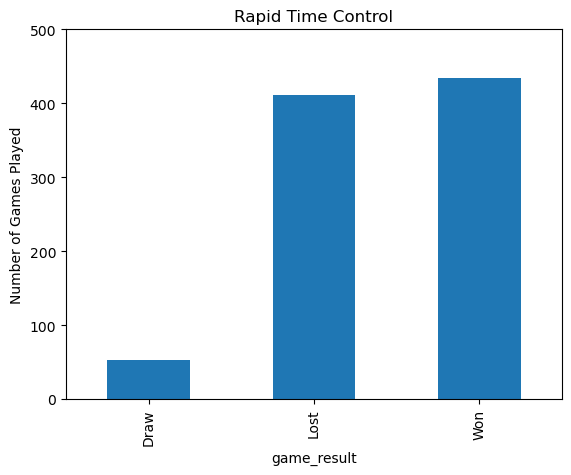

In [29]:
plot_game_result(rapid_games, "Rapid")

**Figure 2**

game_result
Draw     58
Lost    566
Won     564
dtype: int64


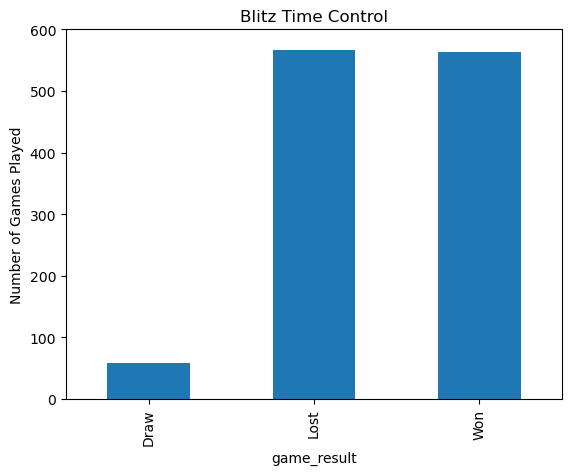

In [30]:
plot_game_result(blitz_games, "Blitz")

**Figure 3**

game_result
Draw      2
Lost    151
Won     153
dtype: int64


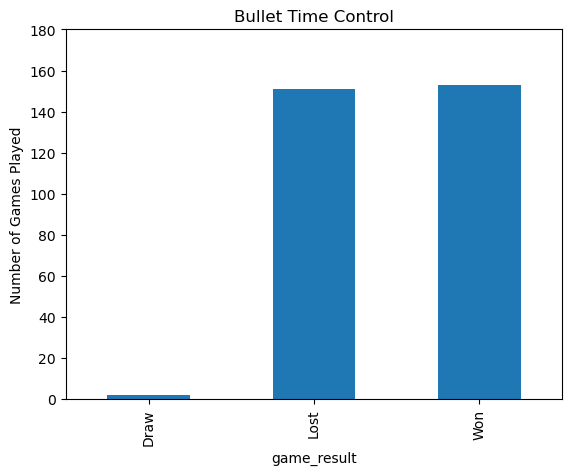

In [31]:
plot_game_result(bullet_games, "Bullet")

**Figure 4**

In [32]:
def plot_rating_over_time(df, time_control):
    """Plots rating over time sampled at a daily frequency.

    Args:
        df (pandas.DataFrame): the chess game data for a particular time control
        time_control (str): time control used in the title for the plot
    """
    (df.resample(rule = "D", on = "end_time")
     .mean(numeric_only = True)["my_rating"]
     .interpolate(method = "time")
     .plot(title = f"{time_control} Game Rating Over Time (Jan 2023 - Present)", grid = True))
    plt.ylabel("Elo Rating")
    plt.show()

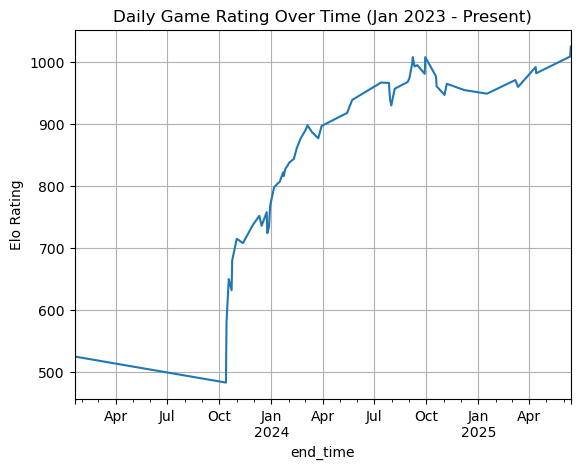

In [33]:
plot_rating_over_time(daily_games, "Daily")

**Figure 5**

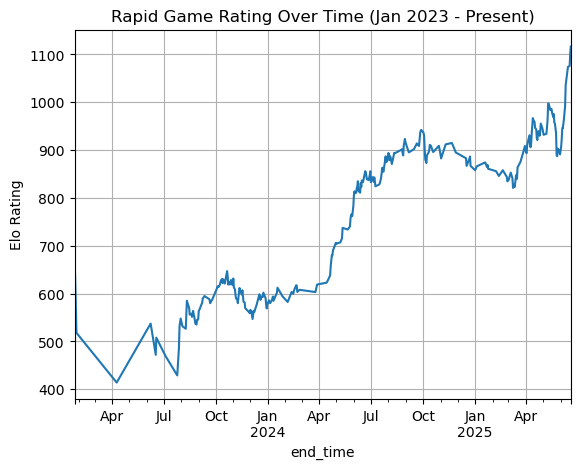

In [34]:
plot_rating_over_time(rapid_games, "Rapid")

**Figure 6**

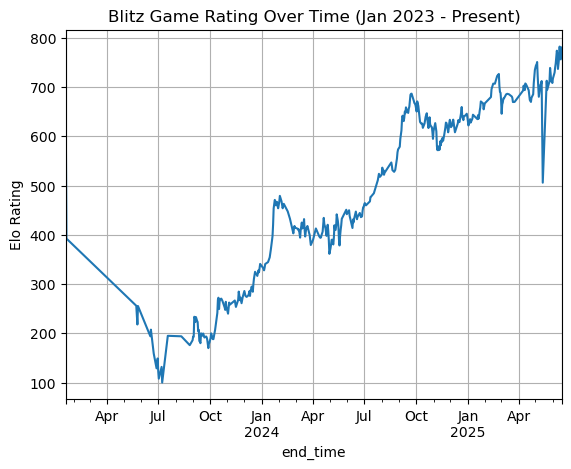

In [35]:
plot_rating_over_time(blitz_games, "Blitz")

**Figure 7**

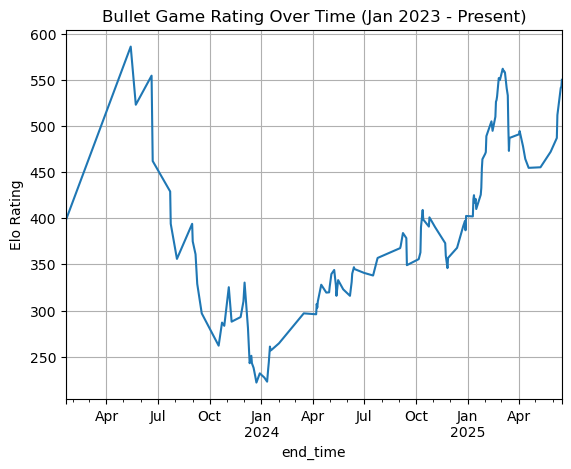

In [36]:
plot_rating_over_time(bullet_games, "Bullet")

**Figure 8**

In [37]:
def plot_openings_by_time_control(df, time_control):
    """Plots the top 10 descending openings played for a given time control.

    Args:
        df (pandas.DataFrame): time control dataframe (i.e. blitz, rapid, daily, or bullet)
        time_control (str): time control used in the title for the plot
    """
    openings = df.groupby("openings").size().sort_values(ascending = False)
    openings[:10].plot(kind = "barh", title = f"Top 10 Openings Played For {time_control} Time Control", xlabel = "Number of Games Played")
    plt.xticks([i for i in range(openings.max() + 1)])
    plt.show()

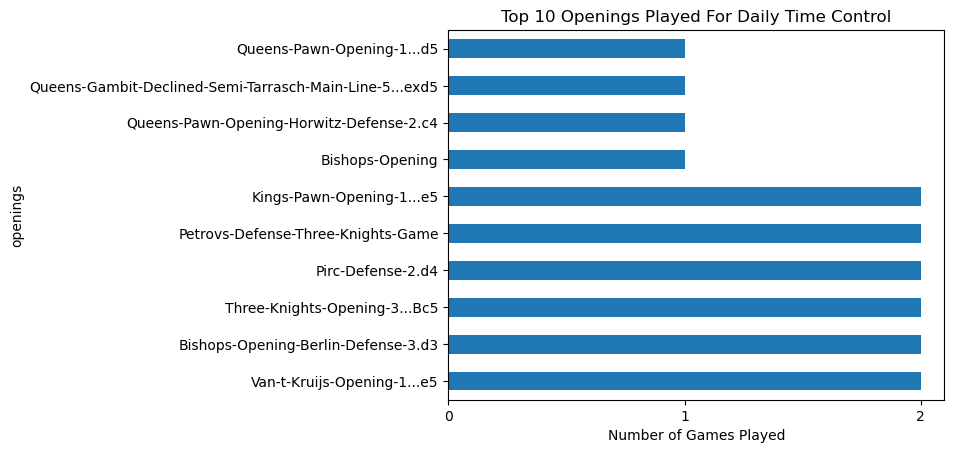

In [38]:
# Top 10 openings played for daily time control
plot_openings_by_time_control(daily_games, "Daily")

**Figure 9**

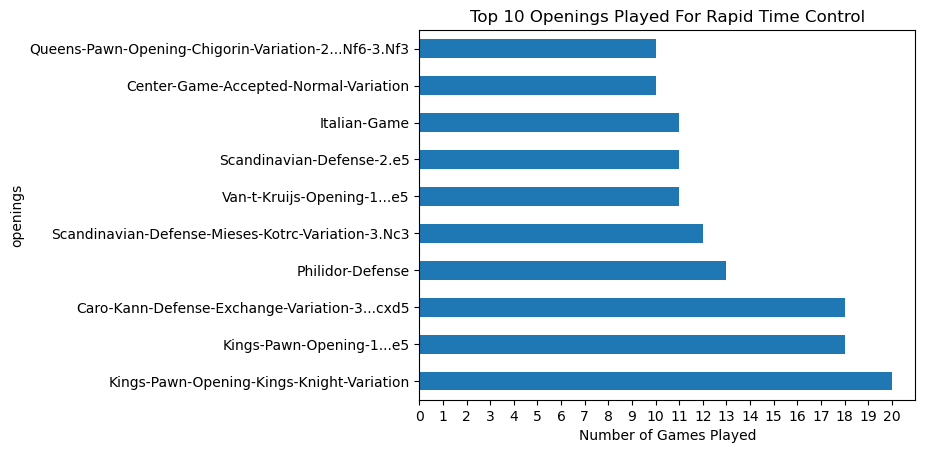

In [39]:
# Top 10 openings played for rapid time control
plot_openings_by_time_control(rapid_games, "Rapid")

**Figure 10**

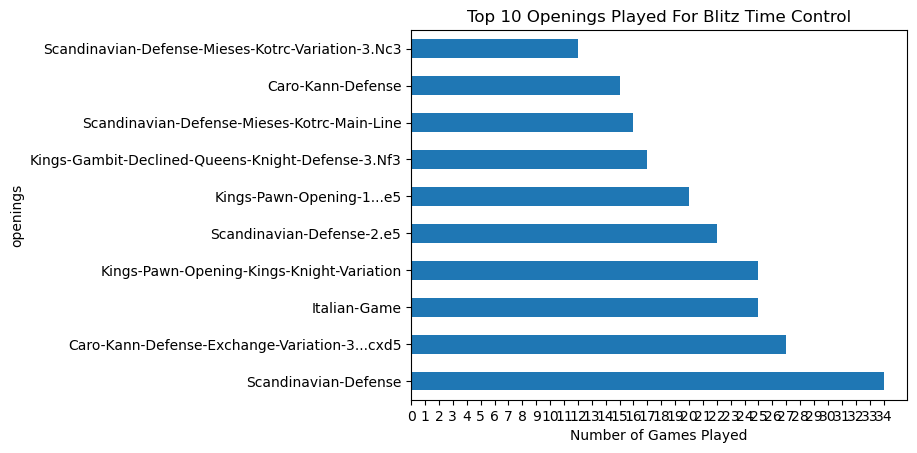

In [40]:
# Top 10 openings played for blitz time control
plot_openings_by_time_control(blitz_games, "Blitz")

**Figure 11**

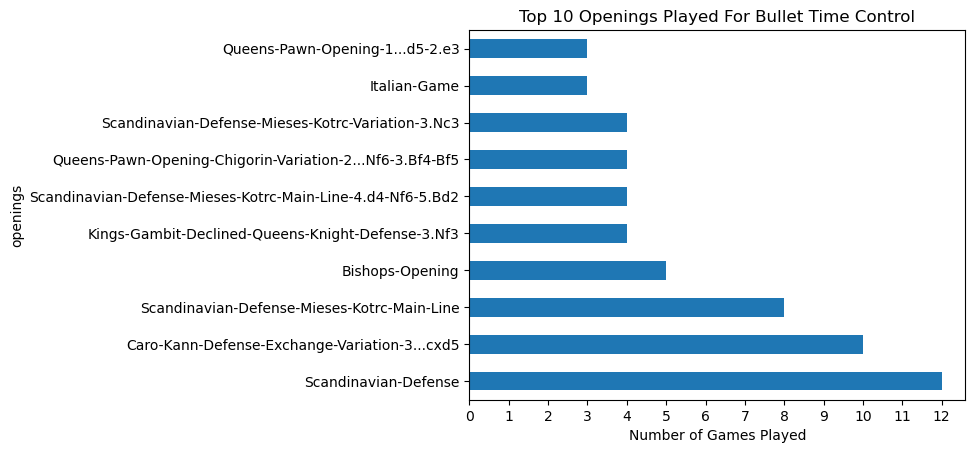

In [41]:
# Top 10 openings played for bullet time control
plot_openings_by_time_control(bullet_games, "Bullet")

**Figure 12**

In [42]:
def plot_openings_matrix(df, time_control):
    """Plots the top 10 descending openings played by game outcome.

    Args:
        df (pandas.DataFrame): time control dataframe
        time_control (str): time control used in the title for the plot
    """
    openings_results = df.groupby(["openings", "game_result"]).size().unstack(fill_value = 0).sort_values(by = "Won", ascending = False)
    ax = sns.heatmap(openings_results[:10], annot=True, cmap='jet')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([int(tick) for tick in cbar.get_ticks()])
    ax.set_title(f"Top 10 Openings Played By Result For {time_control} Time Control")
    plt.show()

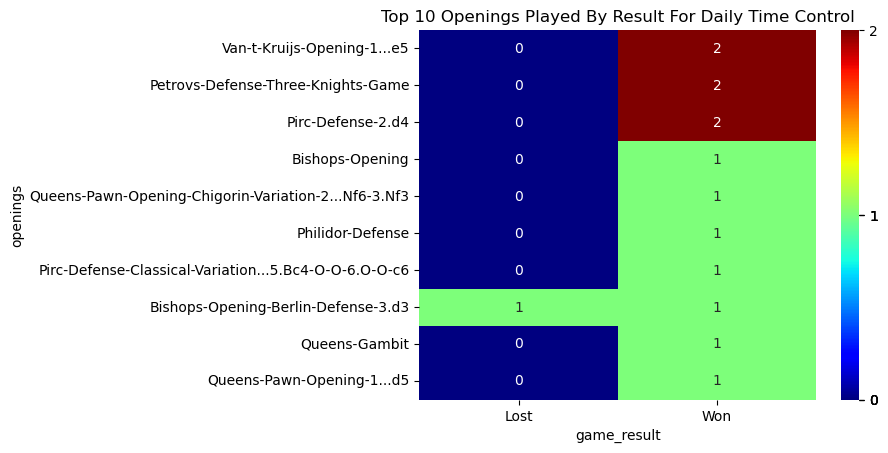

In [43]:
plot_openings_matrix(daily_games, "Daily")

**Figure 13**

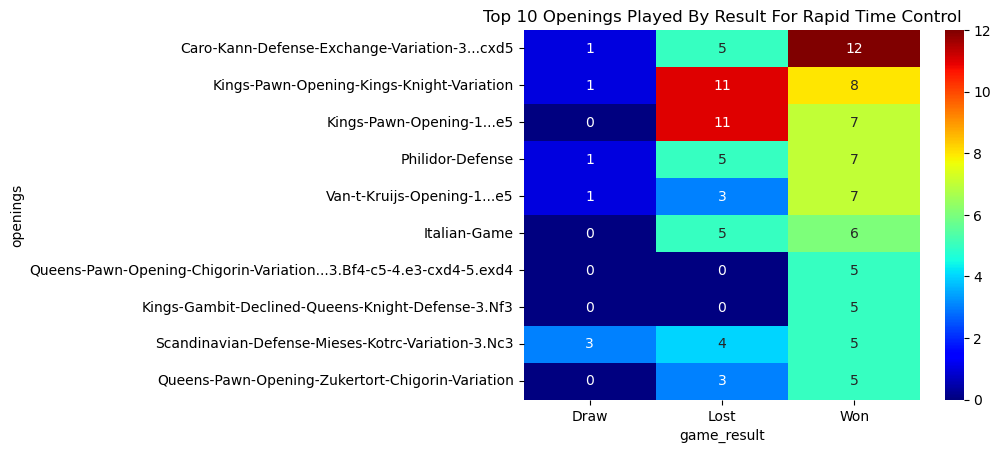

In [44]:
plot_openings_matrix(rapid_games, "Rapid")

**Figure 14**

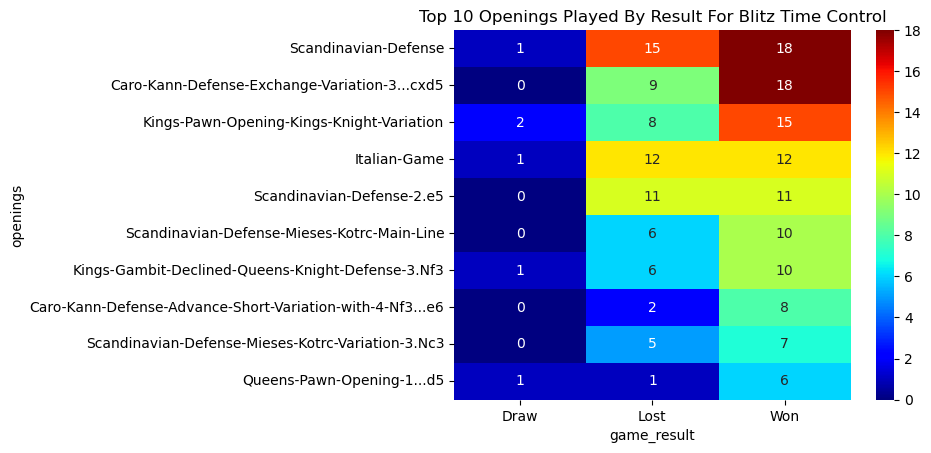

In [45]:
plot_openings_matrix(blitz_games, "Blitz")

**Figure 15**

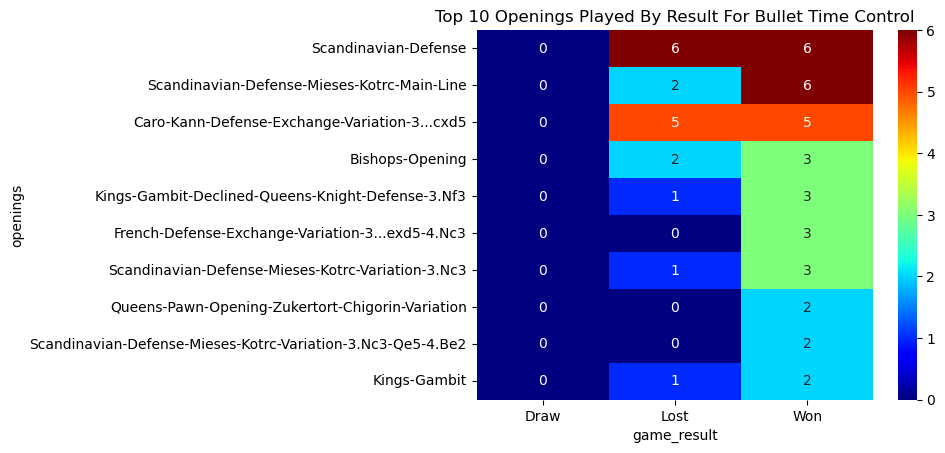

In [46]:
plot_openings_matrix(bullet_games, "Bullet")

**Figure 16**